In [145]:
import pandas as pd

aed_locations = pd.read_csv('aed_locations_coordinates_processed.csv')
card_arrest = pd.read_csv('card_arrest_processed.csv')
all_hospital_locations = pd.read_csv('hospital_coordinates_processed.csv')
removed_aed = pd.read_csv('removed_AED.csv')

In [146]:
#during the data cleaning itself, 3576 AED were removed from the original 15227, equal to 23.48% of the original total. 2825 (18.55% of the total)
#because the coordinates could not be retrieved via Nomatim, for example because the provided address had abbreviations or misspellings.
#749 (4.91%) because they were considered to be unavailable to the public, and thus not useable.
#2 were removed simply because the address was missing.
removed_aed['reason'].value_counts()

reason
missing_coordinates    2825
not_available           749
address_missing           4
Name: count, dtype: int64

In [147]:
#it could provide valuable insight to also plot the removed AED's. However, the vast majority of the AED's were removed because
#it was impossible to get coordinates in the first place. Only a small minority, for which it is clear what the reason is (they are not available)
#can be plotted, but since the reason is clear it is not really useful to plot those in the first place.
import folium

# approximately the center of Belgium coordinates
belgium_center_lat = 50.8503
belgium_center_lon = 4.3517

m = folium.Map(location=[belgium_center_lat, belgium_center_lon], zoom_start=8)

# add cardiac arrests to the map
for _, row in card_arrest.iterrows():
    folium.CircleMarker(
        location=[row['latitude_intervention'], row['longitude_intervention']],
        radius=1,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.2,
        tooltip='Cardiac Arrest'
    ).add_to(m)

# add AED locations to the map
for _, row in aed_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.2,
        tooltip='AED'
    ).add_to(m)

# add hospital locations to the map
for _, row in all_hospital_locations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.2,
        tooltip='Hospital'
    ).add_to(m)

m.save('exploratory_map.html')

In [148]:
#there are also some datapoints outside of belgium, especially for the AED's, AED's that got miscoded during the AED's location
#encoding using nomatim, likely because the address also existed in another country.
#we remove these instances by roughly taking the coordinates of the outermost edges of Belgium. Not all AED's that were miscoded (i.e. being outside
#of Belgium) get removed this way. 32 AED's get remove this way.

#add to the removed_aed data frame
incorrect_aed = aed_locations[
    (aed_locations['longitude'] <= 2.569241) | 
    (aed_locations['longitude'] >= 6.392983) |
    (aed_locations['latitude'] <= 49.479388) | 
    (aed_locations['latitude'] >= 51.556040)
]

incorrect_aed['reason'] = "incorrect_coordinates"

removed_aed = pd.concat([removed_aed, incorrect_aed])

aed_locations = aed_locations[aed_locations['longitude'] > 2.569241] #left
aed_locations = aed_locations[aed_locations['longitude'] < 6.392983] #right
aed_locations = aed_locations[aed_locations['latitude'] > 49.479388] #down
aed_locations = aed_locations[aed_locations['latitude'] < 51.556040] #up
aed_locations

C:\Users\eloua\AppData\Local\Temp\ipykernel_14948\1419426758.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_aed['reason'] = "incorrect_coordinates"


,id,address,number,municipality,latitude,longitude,postal_code,province
0,71.0,Place Saint - Lambert,0,Liège,50.750721,5.933967,4020.0,Liège
1,72.0,Rue du Doyard,0,Lierneux,50.285043,5.785950,4990.0,Liège
2,73.0,Fond Saint Servais,0,Liège,50.646765,5.570987,4000.0,Liège
3,74.0,Rue des Prémontrès,12,Liège,50.638047,5.574046,4020.0,Liège
4,76.0,Rue du Parc,1,Jehay,50.577233,5.323038,4540.0,Liège
...,...,...,...,...,...,...,...,...
11644,16654.0,Farnières,4,Grand Halleux,50.310813,5.880418,6698.0,Liège
11645,16660.0,Chaussée de Marche,799,Wierde,50.426430,4.929522,5100.0,Namur
11646,16661.0,Nekkerspoel-Borcht,19,Mechelen,51.025217,4.504148,2800.0,Antwerpen
11647,16664.0,Nieuwe Dreef,17,Lokeren,51.097802,3.911744,9160.0,Oost-Vlaanderen


It is apparent that within cities the density of cases is highest, regardless of where the city is located. This makes sense since cities are simply more densely populated. The more Southern part of Wallonia has less densely located cardiac arrests compared to the rest of the map, which also makes sense since it is less densely populated. In general the distribution of cardiac cases seems to match the population densities of different areas. Flanders is generally more densely populated, and the cardiac cases are more densely populated there. One last thing to notice is that there seems to be a belt of more densely spread cases which follows the Meuse river.
The spread of the AED's seems to match the spread of the cardiac cases pretty well, although when looking at big cities, for example Brussels City, there seem to be significantly less AED's compared to cardiac cases, compared to for example a smaller town like Overijse.

In [149]:
provinces_aed = aed_locations['province'].unique()
provinces_aed

array(['Liège', 'Bruxelles-Brussel', 'Antwerpen', 'Vlaams-Brabant',
       'Luxembourg', 'Limburg', 'West-Vlaanderen', 'Oost-Vlaanderen',
       'Hainaut', 'Brabant Wallon', 'Namur', nan], dtype=object)

In [150]:
provinces_card = card_arrest['province'].unique()
provinces_card

array(['BRU', 'ANT', 'BRW', 'WVL', 'HAI', 'LIE', 'LIM', 'LUX', 'NAM',
       'VBR', 'OVL'], dtype=object)

In [151]:
card_arrest['province'] = card_arrest['province'].replace({
    'BRU': 'Bruxelles-Brussel',
    'ANT': 'Antwerpen',
    'BRW': 'Brabant Wallon',
    'WVL': 'West-Vlaanderen',
    'HAI': 'Hainaut',
    'LIE': 'Liège',
    'LIM': 'Limburg',
    'LUX': 'Luxembourg',
    'NAM': 'Namur',
    'VBR': 'Vlaams-Brabant',
    'OVL': 'Oost-Vlaanderen'
})
card_arrest

,eventType_trip,latitude_intervention,longitude_intervention,parsed_T0,parsed_T3,time_difference_seconds,province
0,P011 - Chest pain,50.877980,4.392290,2022-09-06 14:51:41.968677,NaN,NaN,Bruxelles-Brussel
1,P011 - Chest pain,50.895780,4.358170,2022-09-06 15:08:52.857352,2022-09-06 14:05:04.521346,-3828.336006,Bruxelles-Brussel
2,P011 - Chest pain,50.855920,4.425920,2022-09-06 16:36:15.795918,2022-09-06 14:50:46.344005,-6329.451913,Bruxelles-Brussel
3,P011 - Chest pain,50.809380,4.347430,2022-09-06 17:14:30.554547,2022-09-06 15:28:15.574171,-6374.980376,Bruxelles-Brussel
4,P039 - Cardiac problem (other than thoracic pain),50.869440,4.360800,2022-09-06 18:21:26.211055,NaN,NaN,Bruxelles-Brussel
...,...,...,...,...,...,...,...
56279,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.980111,3.982742,2023-05-31 19:47:06,2023-05-31 19:56:44,578.000000,Oost-Vlaanderen
56280,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),51.131239,4.111499,2023-05-31 20:41:28,2023-05-31 20:53:46,738.000000,Oost-Vlaanderen
56281,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,50.896206,3.856032,2023-05-31 20:45:48,2023-05-31 20:57:17,689.000000,Oost-Vlaanderen
56282,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.965585,3.758418,2023-05-31 21:38:03,2023-05-31 21:54:16,973.000000,Oost-Vlaanderen


In [152]:
#given that so few are missing, we will simply remove them
missing_province_aed = aed_locations['province'].isnull().sum()
missing_province_aed

aed_locations_province = aed_locations.dropna(subset = ['province'])
aed_locations_province

,id,address,number,municipality,latitude,longitude,postal_code,province
0,71.0,Place Saint - Lambert,0,Liège,50.750721,5.933967,4020.0,Liège
1,72.0,Rue du Doyard,0,Lierneux,50.285043,5.785950,4990.0,Liège
2,73.0,Fond Saint Servais,0,Liège,50.646765,5.570987,4000.0,Liège
3,74.0,Rue des Prémontrès,12,Liège,50.638047,5.574046,4020.0,Liège
4,76.0,Rue du Parc,1,Jehay,50.577233,5.323038,4540.0,Liège
...,...,...,...,...,...,...,...,...
11644,16654.0,Farnières,4,Grand Halleux,50.310813,5.880418,6698.0,Liège
11645,16660.0,Chaussée de Marche,799,Wierde,50.426430,4.929522,5100.0,Namur
11646,16661.0,Nekkerspoel-Borcht,19,Mechelen,51.025217,4.504148,2800.0,Antwerpen
11647,16664.0,Nieuwe Dreef,17,Lokeren,51.097802,3.911744,9160.0,Oost-Vlaanderen


In [153]:
missing_province_card = card_arrest['province'].isnull().sum()
missing_province_card

np.int64(0)

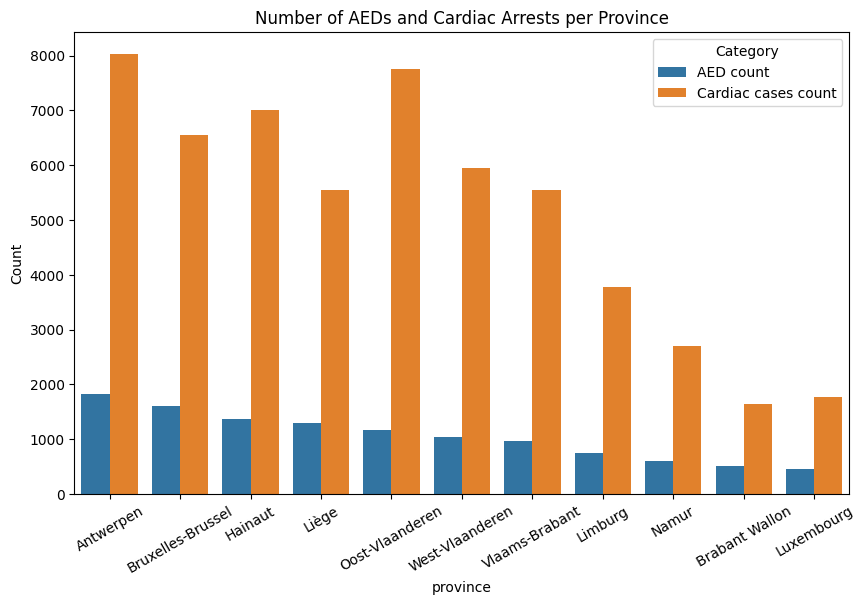

In [156]:
#making some exploratory plots that can be interesting for the stake holder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# count the number of AEDs and Cardiac Arrests per province
aed_counts = aed_locations['province'].value_counts().reset_index()
aed_counts.columns = ['province', 'aed_count']

cardiac_arrest_counts = card_arrest['province'].value_counts().reset_index()
cardiac_arrest_counts.columns = ['province', 'cardiac_arrest_count']

# merge the counts into a single data frame
merged_counts = pd.merge(aed_counts, cardiac_arrest_counts, on='province')

# melt the DataFrame and rename the variable column values
melted_counts = pd.melt(merged_counts, id_vars='province')
melted_counts['variable'] = melted_counts['variable'].replace({
    'aed_count': 'AED count',
    'cardiac_arrest_count': 'Cardiac cases count'
})

plt.figure(figsize=(10, 6))
sns.barplot(x='province', y='value', hue='variable', data=melted_counts)
plt.title('Number of AEDs and Cardiac Arrests per Province')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.legend(title='Category')  # Optional: to add a title to the legend
plt.savefig('aed_cardiac_arrests_per_province.png', bbox_inches='tight')
plt.show()


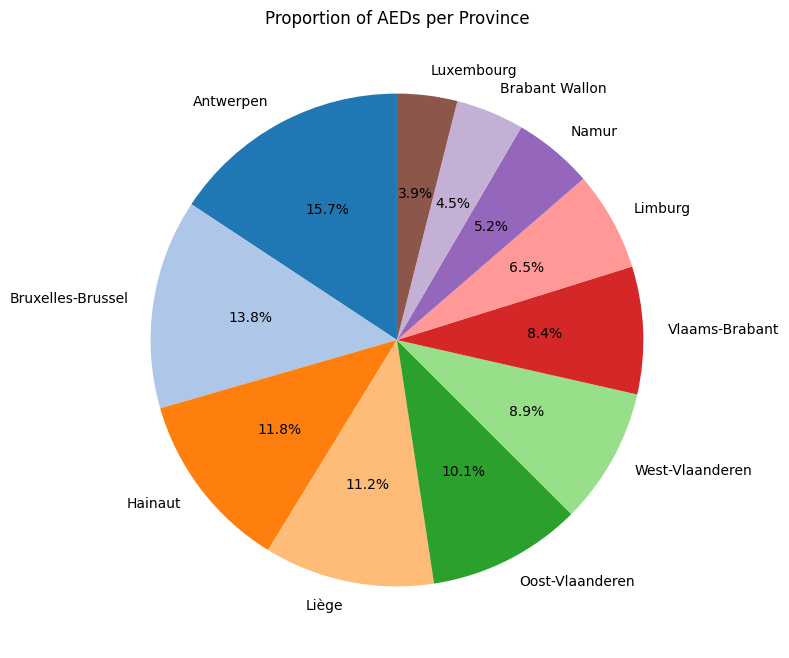

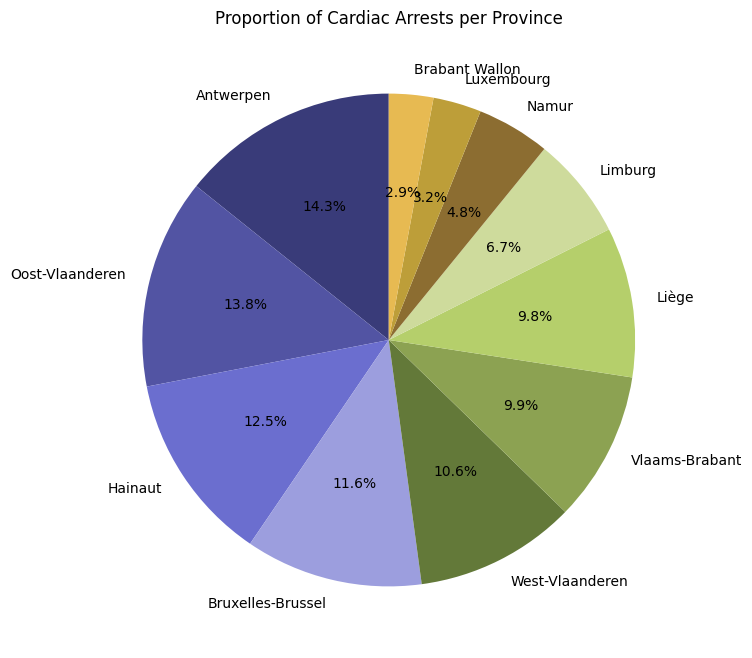

In [158]:
#pie charts showing the proportions
#there are some discrepancies between amount of cardiac arrests and amount of AED's available in the province visible in the pie charts, some examples:
#Brussels has the second most AED's while having the fifth most cardiac arrests
#East-Flanders has the second most cardiac arrests while having the fifth most AED's.
#however, these plots only show the amount of AED's, not how useful they actually are.

aed_province_counts = aed_locations['province'].value_counts()

plt.figure(figsize=(8, 8))
aed_province_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.get_cmap('tab20').colors)
plt.title('Proportion of AEDs per Province')
plt.ylabel('')
plt.savefig('proportion_AED_per_province.png', bbox_inches='tight')
plt.show()

#pie chart for Cardiac Arrests
cardiac_arrest_province_counts = card_arrest['province'].value_counts()

plt.figure(figsize=(8, 8))
cardiac_arrest_province_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.get_cmap('tab20b').colors)
plt.title('Proportion of Cardiac Arrests per Province')
plt.ylabel('')
plt.savefig('proportion_cardiac_per_province.png', bbox_inches='tight')
plt.show()
